In [1]:
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as plticker
import hr_edl_data.plot as mcd_plt
import hr_edl_data.tournament as mcd_tournament

div_color_palette = mcd_plt.diverging_color_palette()
seq_color_palette = mcd_plt.sequential_color_palette()

date = 'jun6_2021'

## Color Selection

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


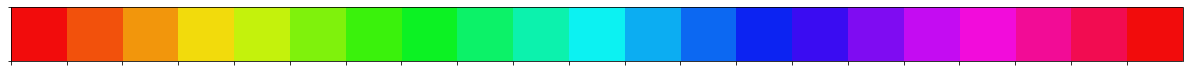

In [2]:
color_palettes = [colorsys.hls_to_rgb(f, 0.5, 0.9) for f in np.arange(0, 1.05, 0.05)]
print(np.arange(0, 1.05, 0.05))
sns.palplot(color_palettes)

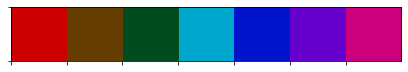

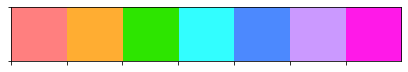

In [3]:
dark_hues = [0, 0.1, 0.4, 0.53, 0.65, 0.75, 0.9]
dark_lightness = [0.4, 0.2, 0.15, 0.4, 0.4, 0.4, 0.4]
light_hues = [1, 0.1, 0.3, 0.5, 0.61, 0.75, 0.85]
light_lightness = [0.75, 0.6, 0.45, 0.6, 0.65, 0.8, 0.55]
dark_colors = [colorsys.hls_to_rgb(h, dark_lightness[i], 1) for i, h in enumerate(dark_hues)]
sns.palplot(dark_colors)
light_colors = [colorsys.hls_to_rgb(h, light_lightness[i], 1) for i, h in enumerate(light_hues)]
sns.palplot(light_colors)

## Configuration

In [4]:
# Setting algorithm comparison groups
hsr_alg_comparisons = (('CFR', 'A-EFR_IN', 'CFR_IN', 'CFR_EX+IN'),)
rla_alg_comparisons = (
    ('CFR', 'A-EFR_IN', 'CFR_IN', 'CFR_EX+IN'),  # Weak algorithms
    ("BPS-EFR", "CFPS-EFR", "CSPS-EFR", 'TIPS-EFR', 'BEHAV-EFR'),  # Strong algorithms
    ("CFPS-EFR", 'TIPS-EFR', "CFPS-EFR_EX+IN", 'TIPS-EFR_EX+IN'),  # Strong EX+IN alternatives
)
nf_algs = ('CFR', 'CFR_IN', 'CFR_EX+IN')
alg_comparisons = rla_alg_comparisons
all_algs = set()
for alg_group in alg_comparisons:
    all_algs = all_algs.union({alg for alg in alg_group})
print(all_algs)

# Setup algorithm specific colors
cf_color_idx = 3
act_color_idx = 6
l1_ps_color_idx = 0
l2_ps_color_idx = 4
alg_color = {
    'CFR': dark_colors[cf_color_idx],
    'A-EFR_IN': dark_colors[act_color_idx],
    'CFR_IN': light_colors[cf_color_idx],
    "BPS-EFR": dark_colors[l1_ps_color_idx],
    "CFPS-EFR": light_colors[l1_ps_color_idx],
    "CSPS-EFR": dark_colors[l2_ps_color_idx],
    'TIPS-EFR': light_colors[l2_ps_color_idx],
    'BEHAV-EFR': (0, 0, 0),
    'CFR_EX+IN': dark_colors[2],
    "CFPS-EFR_EX+IN": dark_colors[1],
    'TIPS-EFR_EX+IN': dark_colors[5],
}
            
learning_curve_query_string = 'game_tag == "{game}" & mode == "{mode}"\
    & col_alg == {col_algs}\
    & row_alg == {algs}'

{'CFPS-EFR', 'BEHAV-EFR', 'TIPS-EFR_EX+IN', 'CFR_EX+IN', 'CFPS-EFR_EX+IN', 'CFR_IN', 'BPS-EFR', 'CSPS-EFR', 'TIPS-EFR', 'CFR', 'A-EFR_IN'}


In [5]:
def reload_data(col_algs=all_algs, row_algs=all_algs):
    '''Load data for the given algorithms.'''
    data = mcd_tournament.Data.load()
    data.data = data.data.query(f'col_alg == {list(col_algs)} & row_alg == {list(row_algs)}')
    return data

In [6]:
data = reload_data()
data.games()

['leduc',
 'goofspiel',
 'goofspiel_ascending',
 'random_goofspiel',
 'goofspiel_3p',
 'goofspiel_ascending_3p',
 'sheriff',
 'tiny_bridge',
 'tiny_hanabi']

In [7]:
avg_learning_curve_ylabel = r'avg.\ payoff'
inst_learning_curve_ylabel = 'payoff'

## Game Specific Functions

In [8]:
def is_goofspiel(game_tag):
    return game_tag[:len('goofspiel')] == 'goofspiel' or game_tag == 'random_goofspiel'

def is_leduc(game_tag):
    return game_tag == 'leduc'

def goofspiel_score_to_win_percentage(df):
    return (df + 1.) / 2.0 * 100

def leduc_score_to_milli_antes(df):
    return df * 1000

def set_learning_curve_ylabel(game_tag, ax, avg=True):
    if is_goofspiel(game_tag):
        ax.set_ylabel(r'avg.\ win \%' if avg else r'win \%')
    elif is_leduc(game_tag):
        ax.set_ylabel(
            fr'{avg_learning_curve_ylabel if avg else inst_learning_curve_ylabel} (mbb)')
    else:
        ax.set_ylabel(
            fr'{avg_learning_curve_ylabel if avg else inst_learning_curve_ylabel}')

## Data Functions

In [9]:
def learning_curve_data(game_tag, df, cumsum=True):
    _df = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='value')
    normalizer = 1.0
    if cumsum:
        _df = _df.cumsum(axis=1)
        normalizer += _df.columns.to_numpy()
    _df = (_df.mean(level=1) / normalizer).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)
    if is_leduc(game_tag):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game_tag):
        _df = goofspiel_score_to_win_percentage(_df)
    return _df

def learning_curve_runtime_data(df):
    df_milliseconds = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='milliseconds')
    _df = df_milliseconds.mean(level=1).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)
    return _df.cumsum()

## Plotting Functions

In [10]:
def sharex_and_y_in_row(axes_list):
    shared_x = axes_list[0].get_shared_x_axes()
    shared_y = axes_list[0].get_shared_y_axes()
    for ax in axes_list[1:]:
        shared_x.join(axes_list[0], ax)
        shared_y.join(axes_list[0], ax)
        
def sharex_in_row(axes_list):
    for j, ax in enumerate(axes_list[1:]):
        axes_list[j - 1].sharex(ax)

def learning_curve_figsize(games, alg_comparisons):
    return (5 + 1)/1.4 * len(alg_comparisons), 3.5/1.4 * len(games)

def learning_curves_adjust_spacing():
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

def learning_curves_subplots(games, alg_comparisons):
    return plt.subplots(
        len(games),
        len(alg_comparisons),
        squeeze=False,
        figsize=learning_curve_figsize(games, alg_comparisons)
#         gridspec_kw={
#             'height_ratios': [1, 1, 1, 1, 1, 1, 1, 1, 1.5]}
#             'width_ratios': [0.25, 1, 1]}
    )

def learning_curves_legend(ax, ncol=2):
    ax.legend(
        ncol=ncol,
        fontsize='x-small',
        columnspacing=0.5,
        labelspacing=0.25,
        handletextpad=0.4,
        handlelength=0.5)
    
def is_int(n):
    return np.round(n) == n

def learning_curves_xticks(ax):
    _, end = ax.get_xlim()
    int_start = 0
    margin = (end - int_start) / 30.
    num_xticks = 5
    interval = (end - int_start) / float(num_xticks)
    return [
        int_start + i * interval for i in range(int_start, num_xticks + 1)
    ]

def learning_curves_set_xticks(ax, xticks):
    ax.xaxis.set_major_locator(plticker.FixedLocator(xticks))
    if all([is_int(n) for n in xticks]):
        ax.xaxis.set_major_formatter(plticker.FormatStrFormatter('%d'))
    else:
        ax.xaxis.set_major_formatter(plticker.FormatStrFormatter('%0.1f'))

def learning_curves_set_yticks(ax):
    loc = plticker.LinearLocator(4)
    ax.yaxis.set_major_locator(loc)
    ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%0.1f'))

def hide_xtick_labels(ax):
    ax.set(xticklabels=[])
def hide_ytick_labels(ax):
    ax.set(yticklabels=[])

In [11]:
def each_game_in_round_learning_curve(games=data.games(), verbose=False):
    for i, game_tag in enumerate(
        sorted(games, key=mcd_tournament.game_sort_key)
    ):
        if verbose: print(game_tag)
        yield i, game_tag

def plot_round_learning_curves(
        ax, game, mode, alg_group, col_algs,
        label_fn=mcd_tournament.alg_label, color_fn=lambda alg: alg_color[alg], cumsum=True,
        show_legend=True, lw=2, alpha=0.8):
    ax.grid("on")
    _df = learning_curve_data(
        game,
        data.data.query(
            learning_curve_query_string.format(
                game=game,
                mode=mode,
                algs=alg_group,
                col_algs=col_algs)),
        cumsum=cumsum)
    for alg in _df.columns:
        ax.plot(
            _df.index.to_numpy() + 1.0,
            _df[alg],
            lw=lw,
            alpha=alpha,
            label=label_fn(alg),
            color=color_fn(alg)
        )
    if show_legend:
        learning_curves_legend(ax)
    
def plot_all_round_learning_curves(
        axes_list, mode,
        alg_groups_list=alg_comparisons, col_algs=list(all_algs), nf_algs=nf_algs, games=data.games(),
        cumsum=True,
        show_legend=True,
        label_fn=mcd_tournament.alg_label, color_fn=lambda alg: alg_color[alg],
        lw=2, alpha=0.8, verbose=True):
    for i, game_tag in each_game_in_round_learning_curve(games=games, verbose=verbose):
        sharex_and_y_in_row(axes_list[i, :])
        if game_tag == 'tiny_hanabi':
            _alg_comparisons = [nf_algs]
            for ax in axes_list[i, 1:]:
                ax.set_axis_off()
        else:
            _alg_comparisons = alg_groups_list
        for j, alg_group in enumerate(_alg_comparisons):
            plot_round_learning_curves(
                axes_list[i, j],
                game_tag,
                mode,
                alg_group,
                col_algs,
                label_fn=label_fn,
                color_fn=color_fn,
                cumsum=cumsum,
                show_legend=show_legend,
                lw=lw,
                alpha=alpha)

In [12]:
runtime_games = [game for game in data.games() if game != 'tiny_hanabi']

def each_game_in_runtime_learning_curve(verbose=False):
    for i, game_tag in enumerate(
        sorted(runtime_games, key=mcd_tournament.game_sort_key)
    ):
        if verbose: print(game_tag)
        yield i, game_tag

def runtime_learning_curve_data(game_tag, df, cumsum=True):
    return learning_curve_data(game_tag, df), learning_curve_runtime_data(df)

def plot_runtime_learning_curves(ax, game, mode, alg_group, col_algs, lw=2, alpha=0.8):
    ax.grid("on")
    _df, _df_runtime = runtime_learning_curve_data(
        game,
        data.data.query(
            learning_curve_query_string.format(
                game=game,
                mode=mode,
                algs=alg_group,
                col_algs=col_algs)))
    time_scale = 1000.
    for alg in _df.columns:
        ax.plot(
            _df_runtime[alg] / time_scale,
            _df[alg],
            lw=lw,
            alpha=alpha,
            label=mcd_tournament.alg_label(alg),
            color=alg_color[alg])
    learning_curves_legend(ax)
    
def plot_all_runtime_learning_curves(axes_list, mode, lw=2, alpha=0.8, verbose=True):
    for i, game_tag in each_game_in_runtime_learning_curve(verbose=verbose):
        sharex_and_y_in_row(axes_list[i, :])
        for j, alg_group in enumerate(alg_comparisons):
            plot_runtime_learning_curves(
                axes_list[i, j],
                game_tag,
                mode,
                alg_group,
                list(all_algs),
                lw=lw,
                alpha=alpha)

## Learning Curves

### Runtime

leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/runtime_learning_curves.fixed.jun6_2021.pdf'.
leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/runtime_learning_curves.sim.jun6_2021.pdf'.


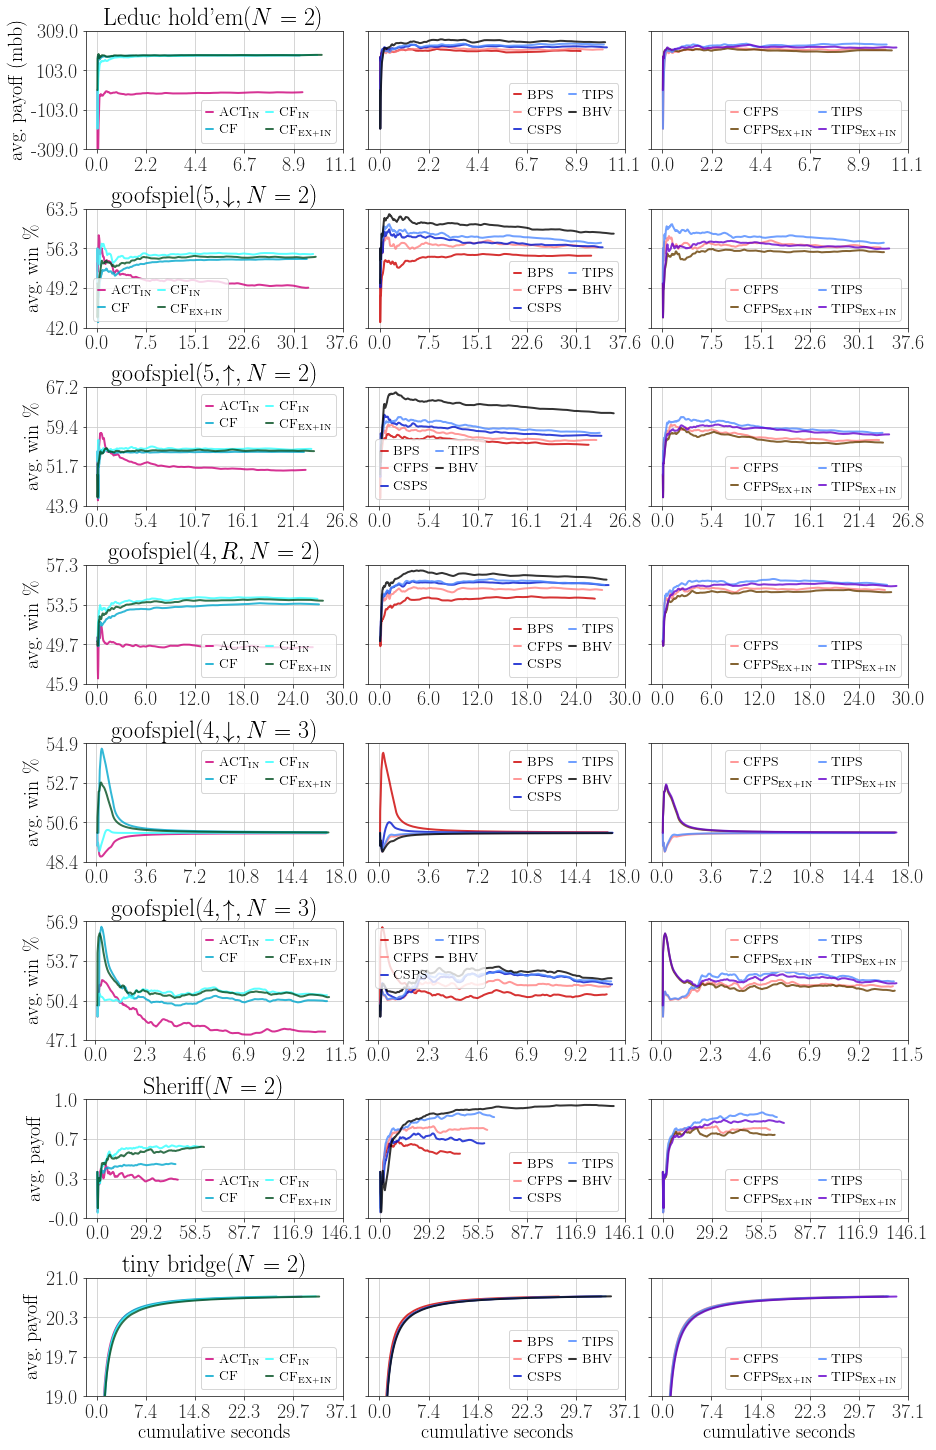

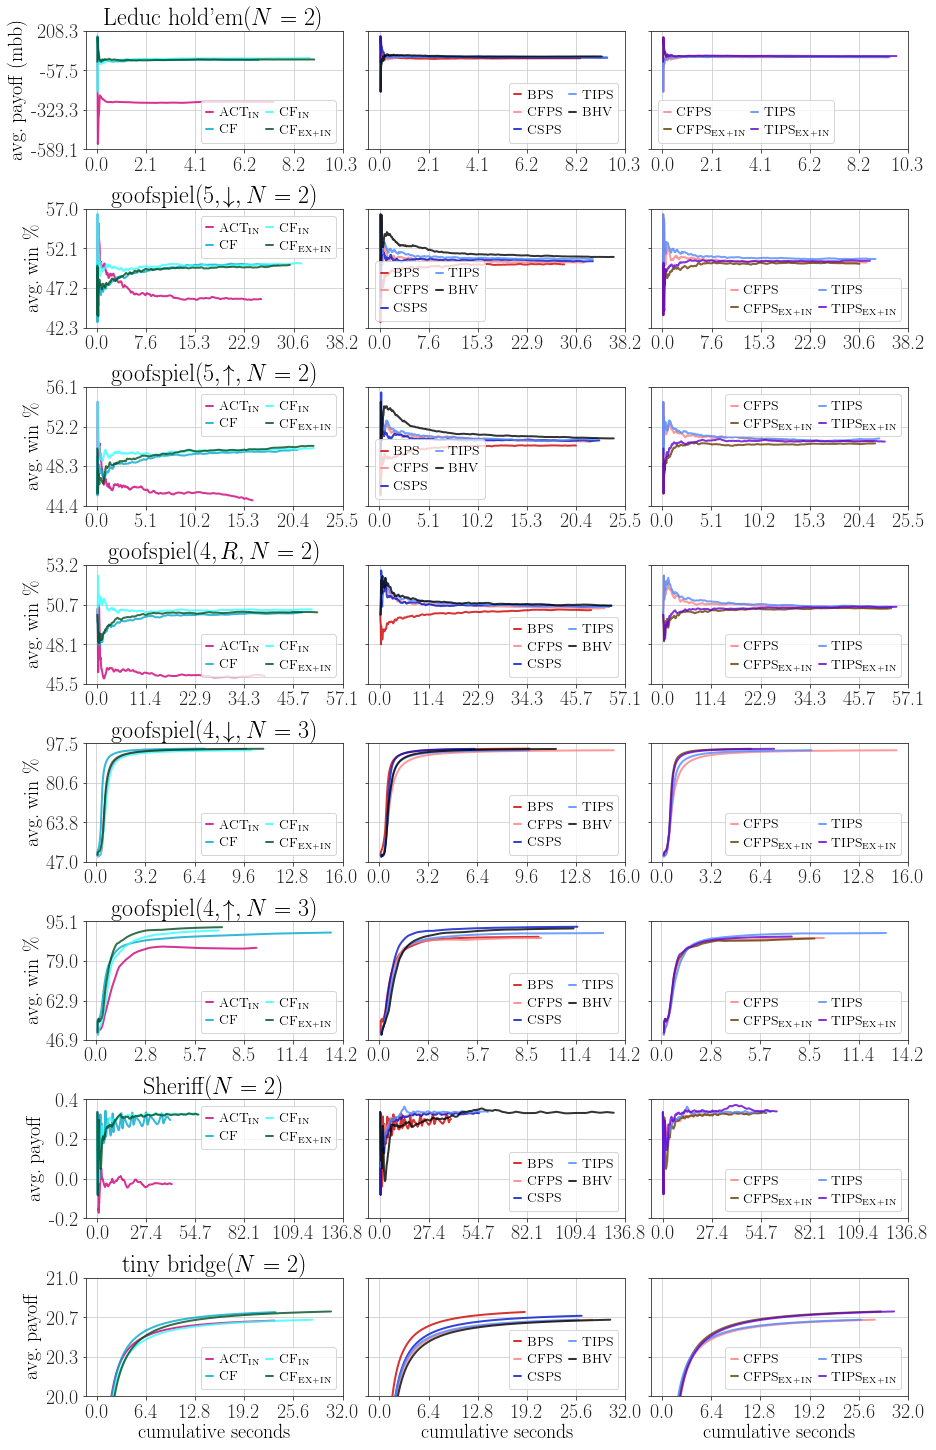

In [13]:
mcd_plt.set_plt_params(font_size=20)

ylim_by_game_list = [
    {
        'tiny_bridge': (19, 21),
        'leduc': (-309, 309),
    },
    {'tiny_bridge': (20, 21)},
]
modes = ['fixed', 'sim']
for k, mode in enumerate(modes):
    fig, axes_list = learning_curves_subplots(runtime_games, alg_comparisons)
    plot_all_runtime_learning_curves(axes_list, mode)
    ylim_by_game = ylim_by_game_list[k]
    for i, game_tag in each_game_in_runtime_learning_curve():
        if game_tag in ylim_by_game:
            axes_list[i, 0].set_ylim(ylim_by_game[game_tag])
    for i in range(axes_list.shape[0]):
        xticks = learning_curves_xticks(axes_list[i, 0])
        for j in range(axes_list.shape[1]):
            learning_curves_set_xticks(axes_list[i, j], xticks)
            learning_curves_set_yticks(axes_list[i, j])
            if j > 0:
                hide_ytick_labels(axes_list[i, j])
    for i, game_tag in each_game_in_runtime_learning_curve():
        ax = axes_list[i, 0]
        set_learning_curve_ylabel(game_tag, ax, avg=True)
        ax.set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[-1, 0:]:
        ax.set_xlabel('cumulative seconds')
    learning_curves_adjust_spacing()
    plot_file = f'../results/runtime_learning_curves.{mode}.{date}.pdf'
    plt.savefig(plot_file)
    !pdfcrop {plot_file} {plot_file}

### Rounds

leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/round_learning_curves.fixed.inst.jun6_2021.pdf'.
leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/round_learning_curves.sim.inst.jun6_2021.pdf'.
leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/round_learning_curves.fixed.cumulative.jun6_2021.pdf'.
leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by

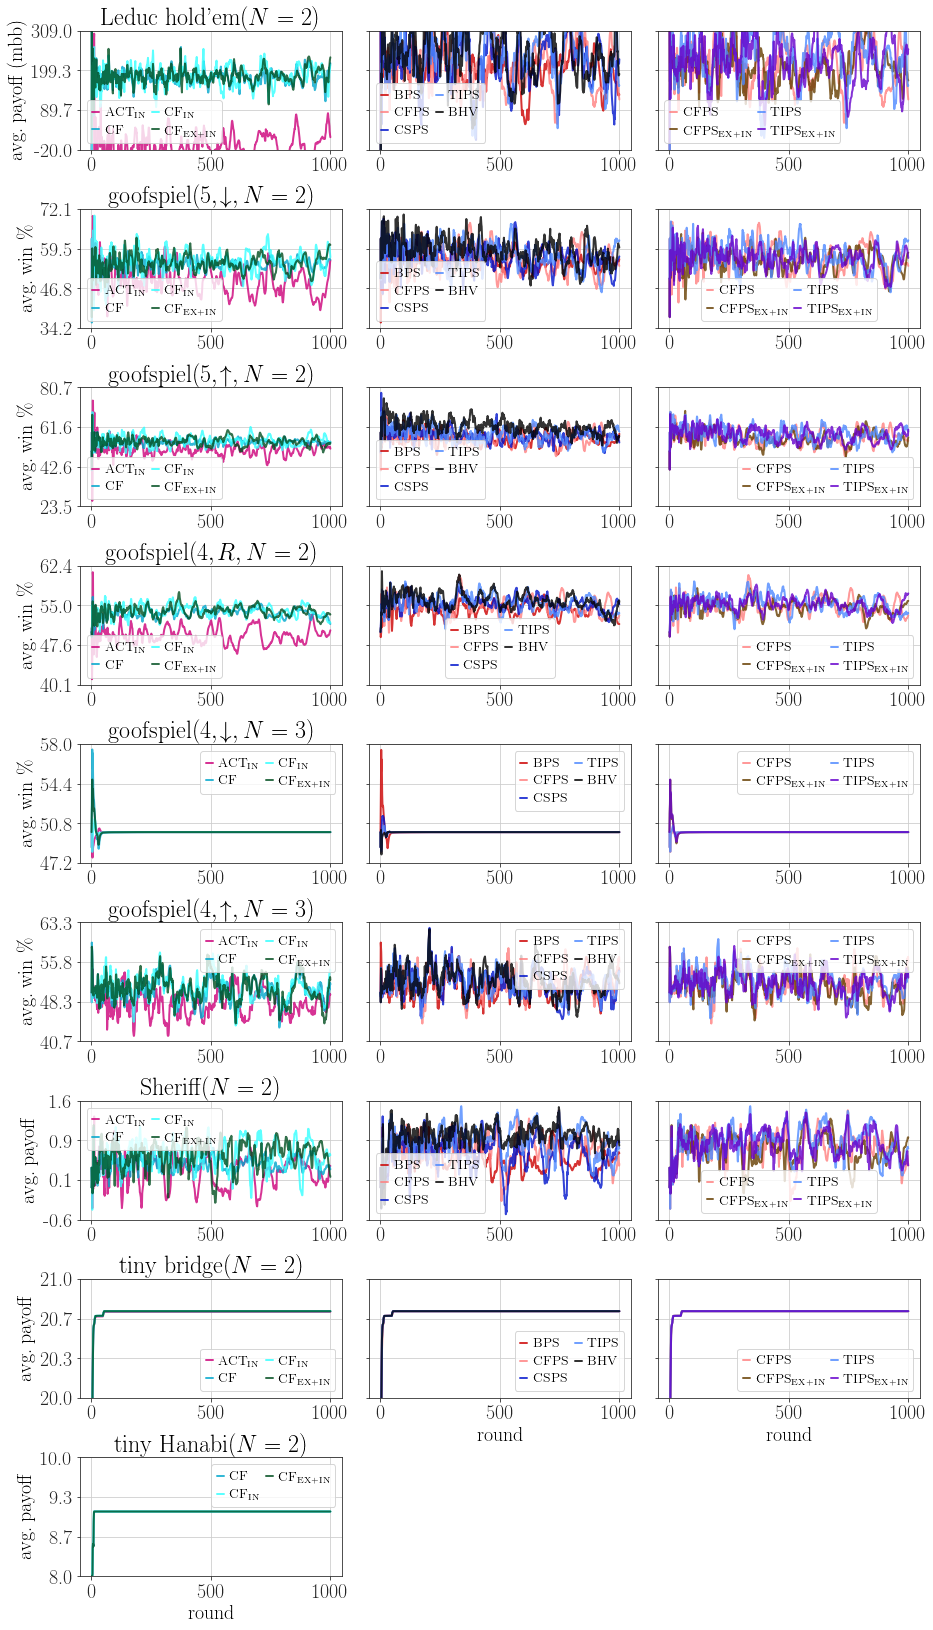

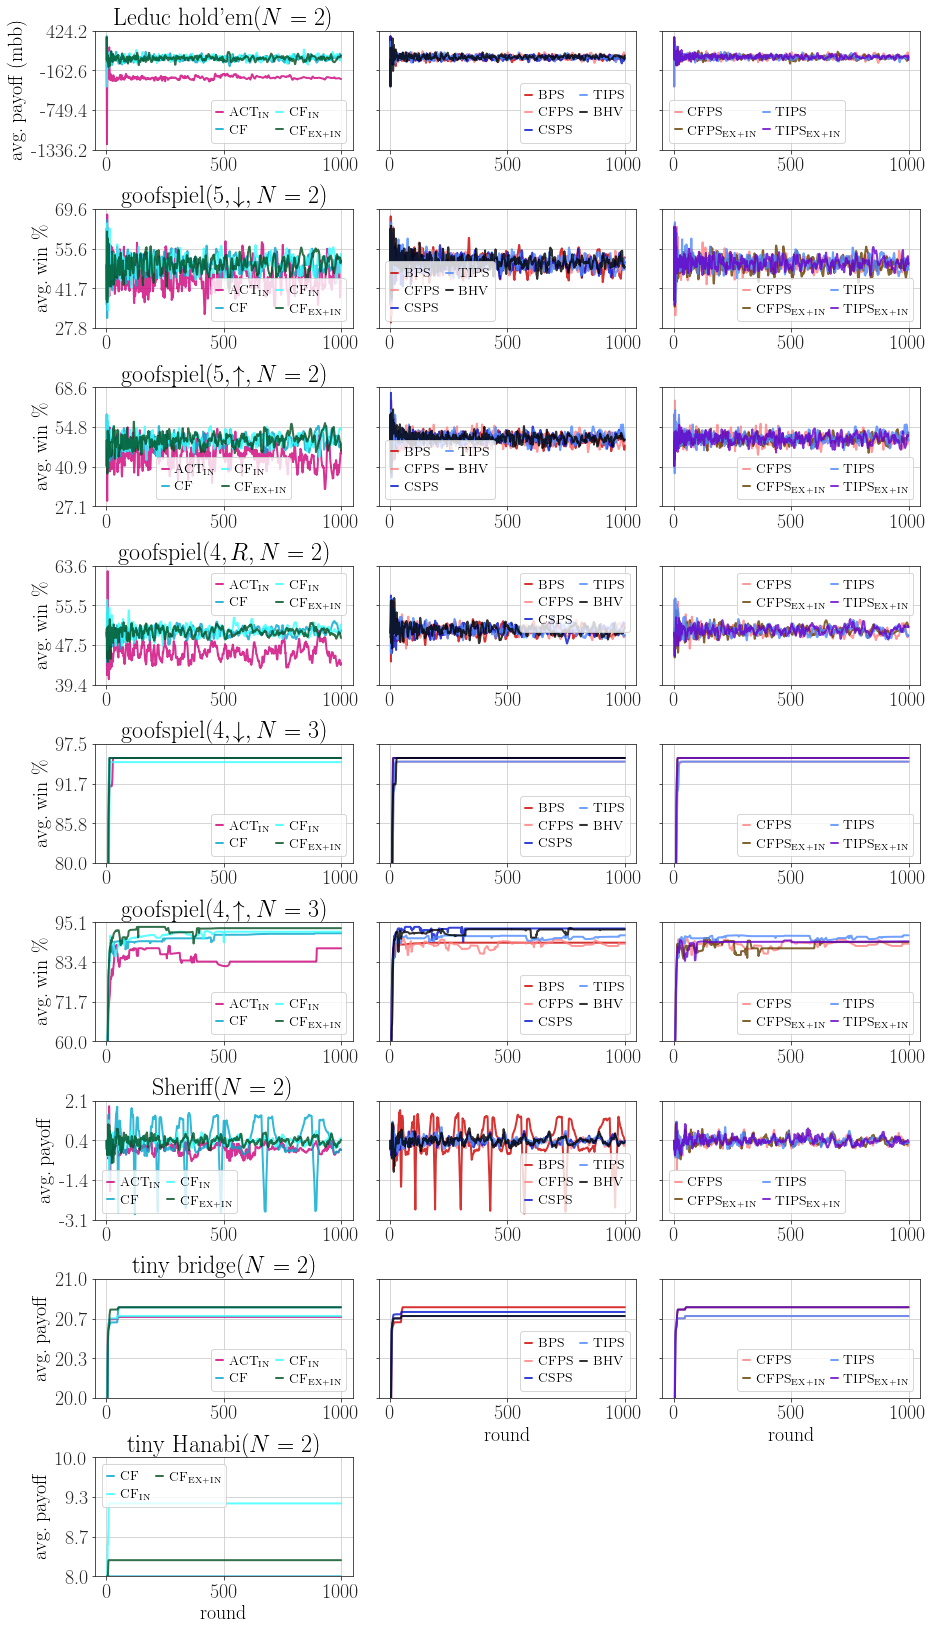

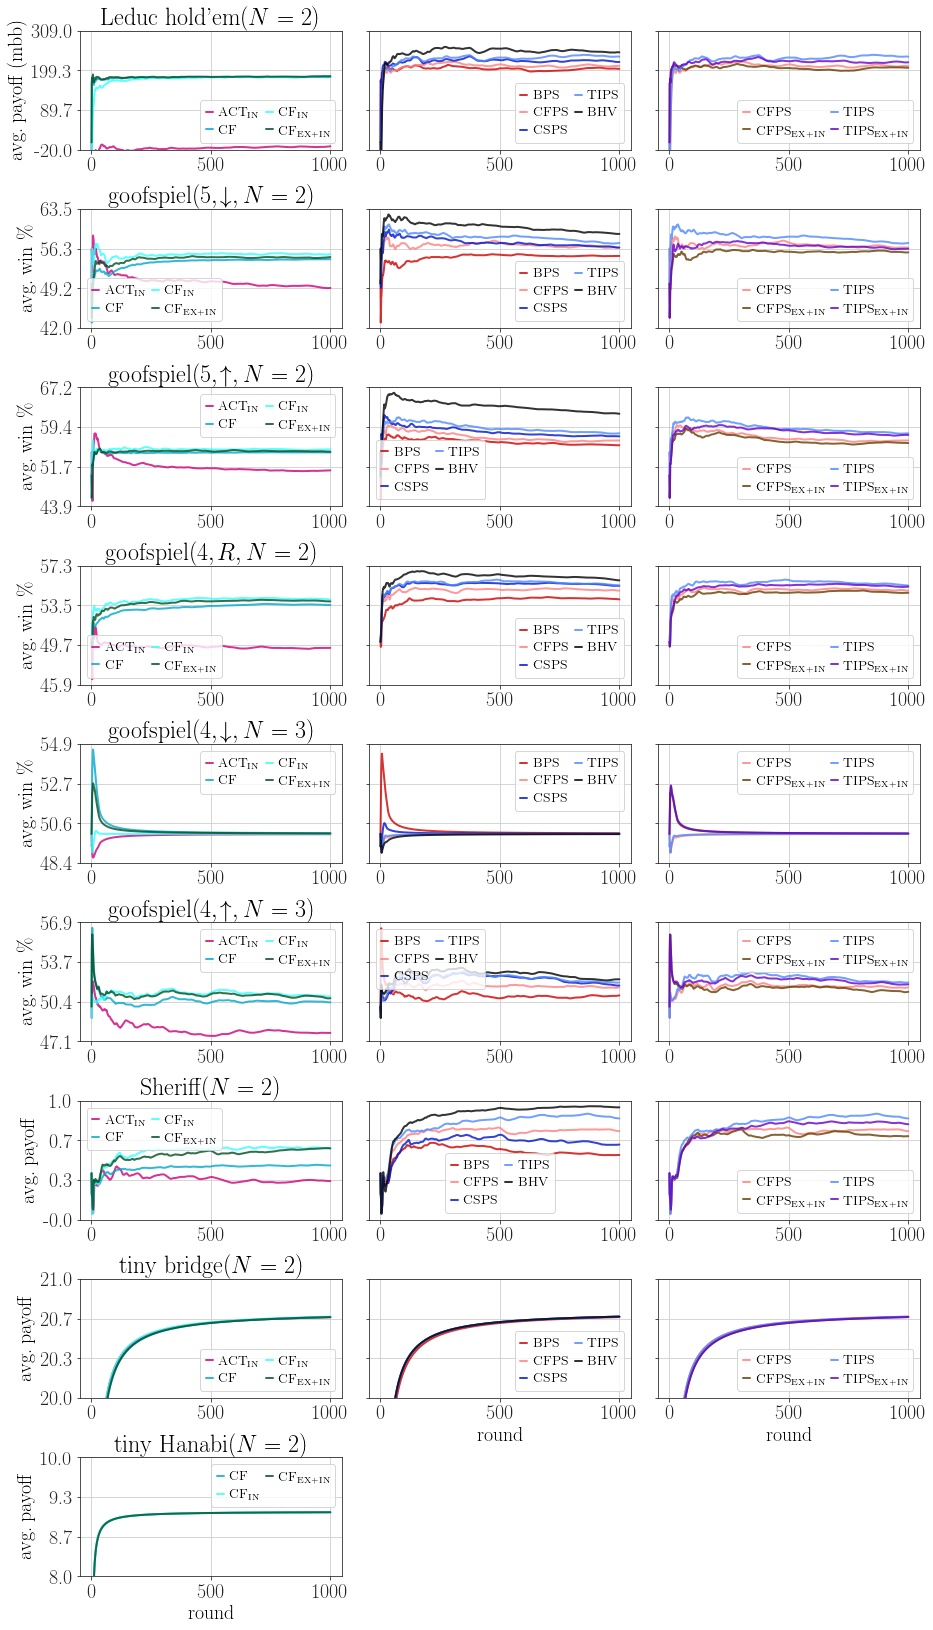

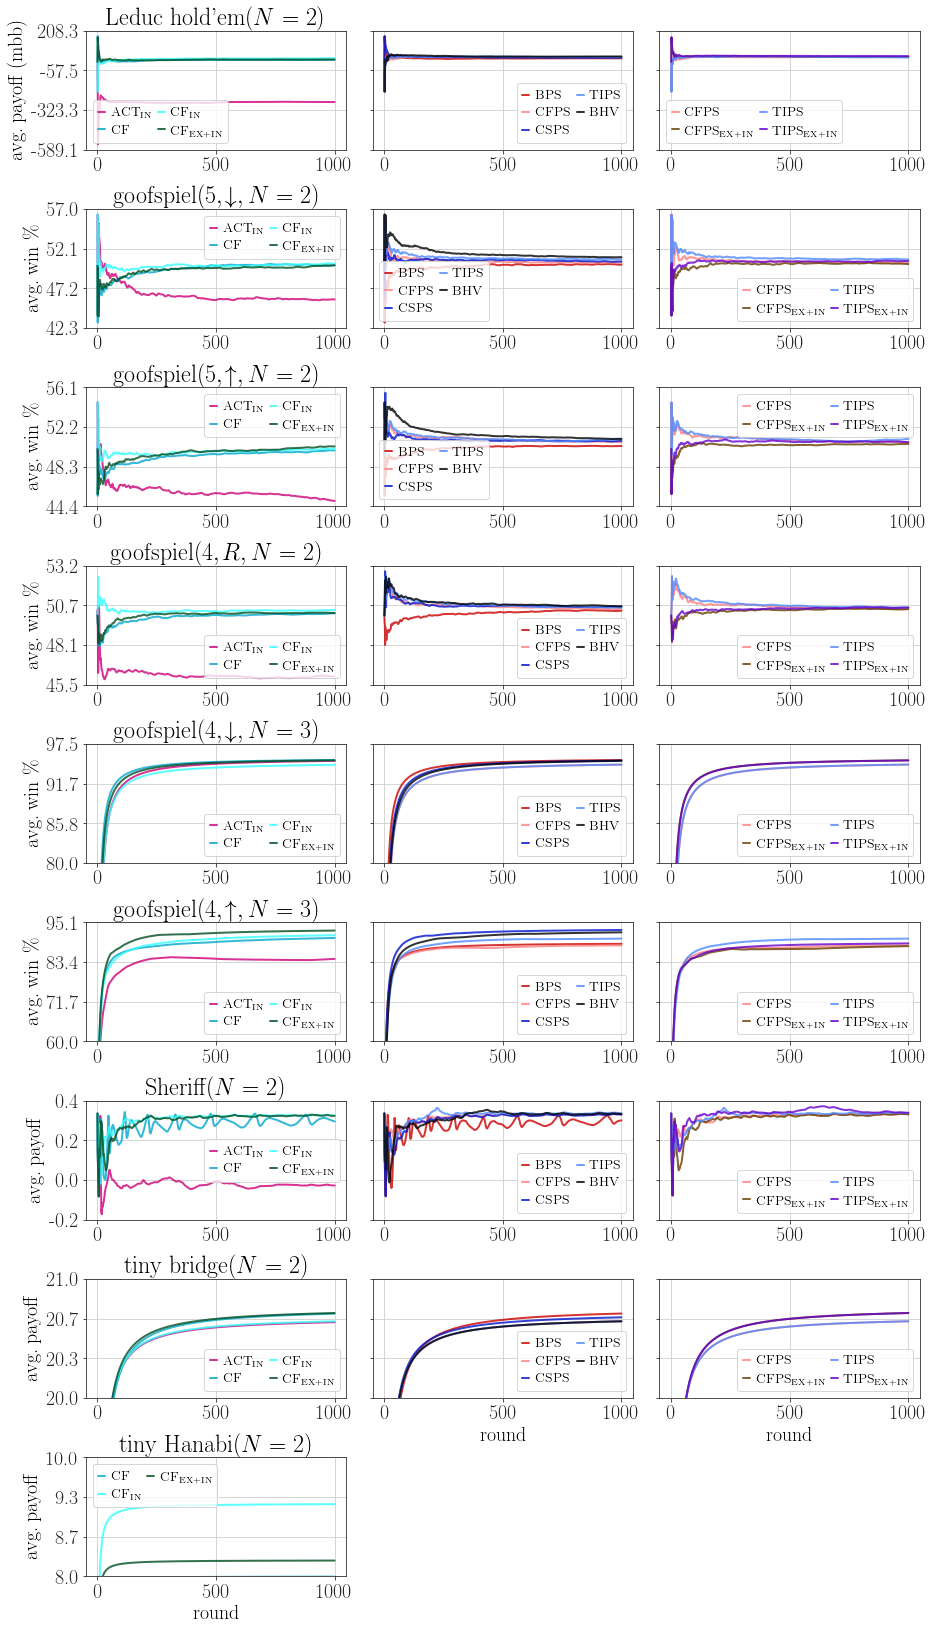

In [14]:
mcd_plt.set_plt_params(font_size=20)

ylim_by_game_list = [
    {
        'tiny_bridge': (20, 21),
        'tiny_hanabi': (8, 10),
        'leduc': (-20, 309),
    },
    {
        'goofspiel_3p': (80, 97.5),
        'goofspiel_ascending_3p': (60, 95.1),
        'tiny_bridge': (20, 21),
        'tiny_hanabi': (8, 10),
    },
]
modes = ['fixed', 'sim']
cumsum_label = ['inst', 'cumulative']
for cumsum_mode in range(2):
    for k, mode in enumerate(modes):
        fig, axes_list = learning_curves_subplots(data.games(), alg_comparisons)
        plot_all_round_learning_curves(axes_list, mode, cumsum=bool(cumsum_mode))
        ylim_by_game = ylim_by_game_list[k]
        for i, game_tag in each_game_in_round_learning_curve():
            if game_tag in ylim_by_game:
                axes_list[i, 0].set_ylim(ylim_by_game[game_tag])
        for i in range(axes_list.shape[0]):
            for j in range(axes_list.shape[1]):
                learning_curves_set_yticks(axes_list[i, j])
                if j > 0:
                    hide_ytick_labels(axes_list[i, j])
        for i, game_tag in each_game_in_round_learning_curve():
            ax = axes_list[i, 0]
            set_learning_curve_ylabel(game_tag, ax, avg=True)
            ax.set_title(mcd_tournament.game_label(game_tag))
        axes_list[-1, 0].set_xlabel('round')
        axes_list[-2, 1].set_xlabel('round')
        axes_list[-2, 2].set_xlabel('round')
        learning_curves_adjust_spacing()
        plot_file = f'../results/round_learning_curves.{mode}.{cumsum_label[cumsum_mode]}.{date}.pdf'
        plt.savefig(plot_file)
        !pdfcrop {plot_file} {plot_file}

leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/heatmaps.jun6_2021-2.pdf'.


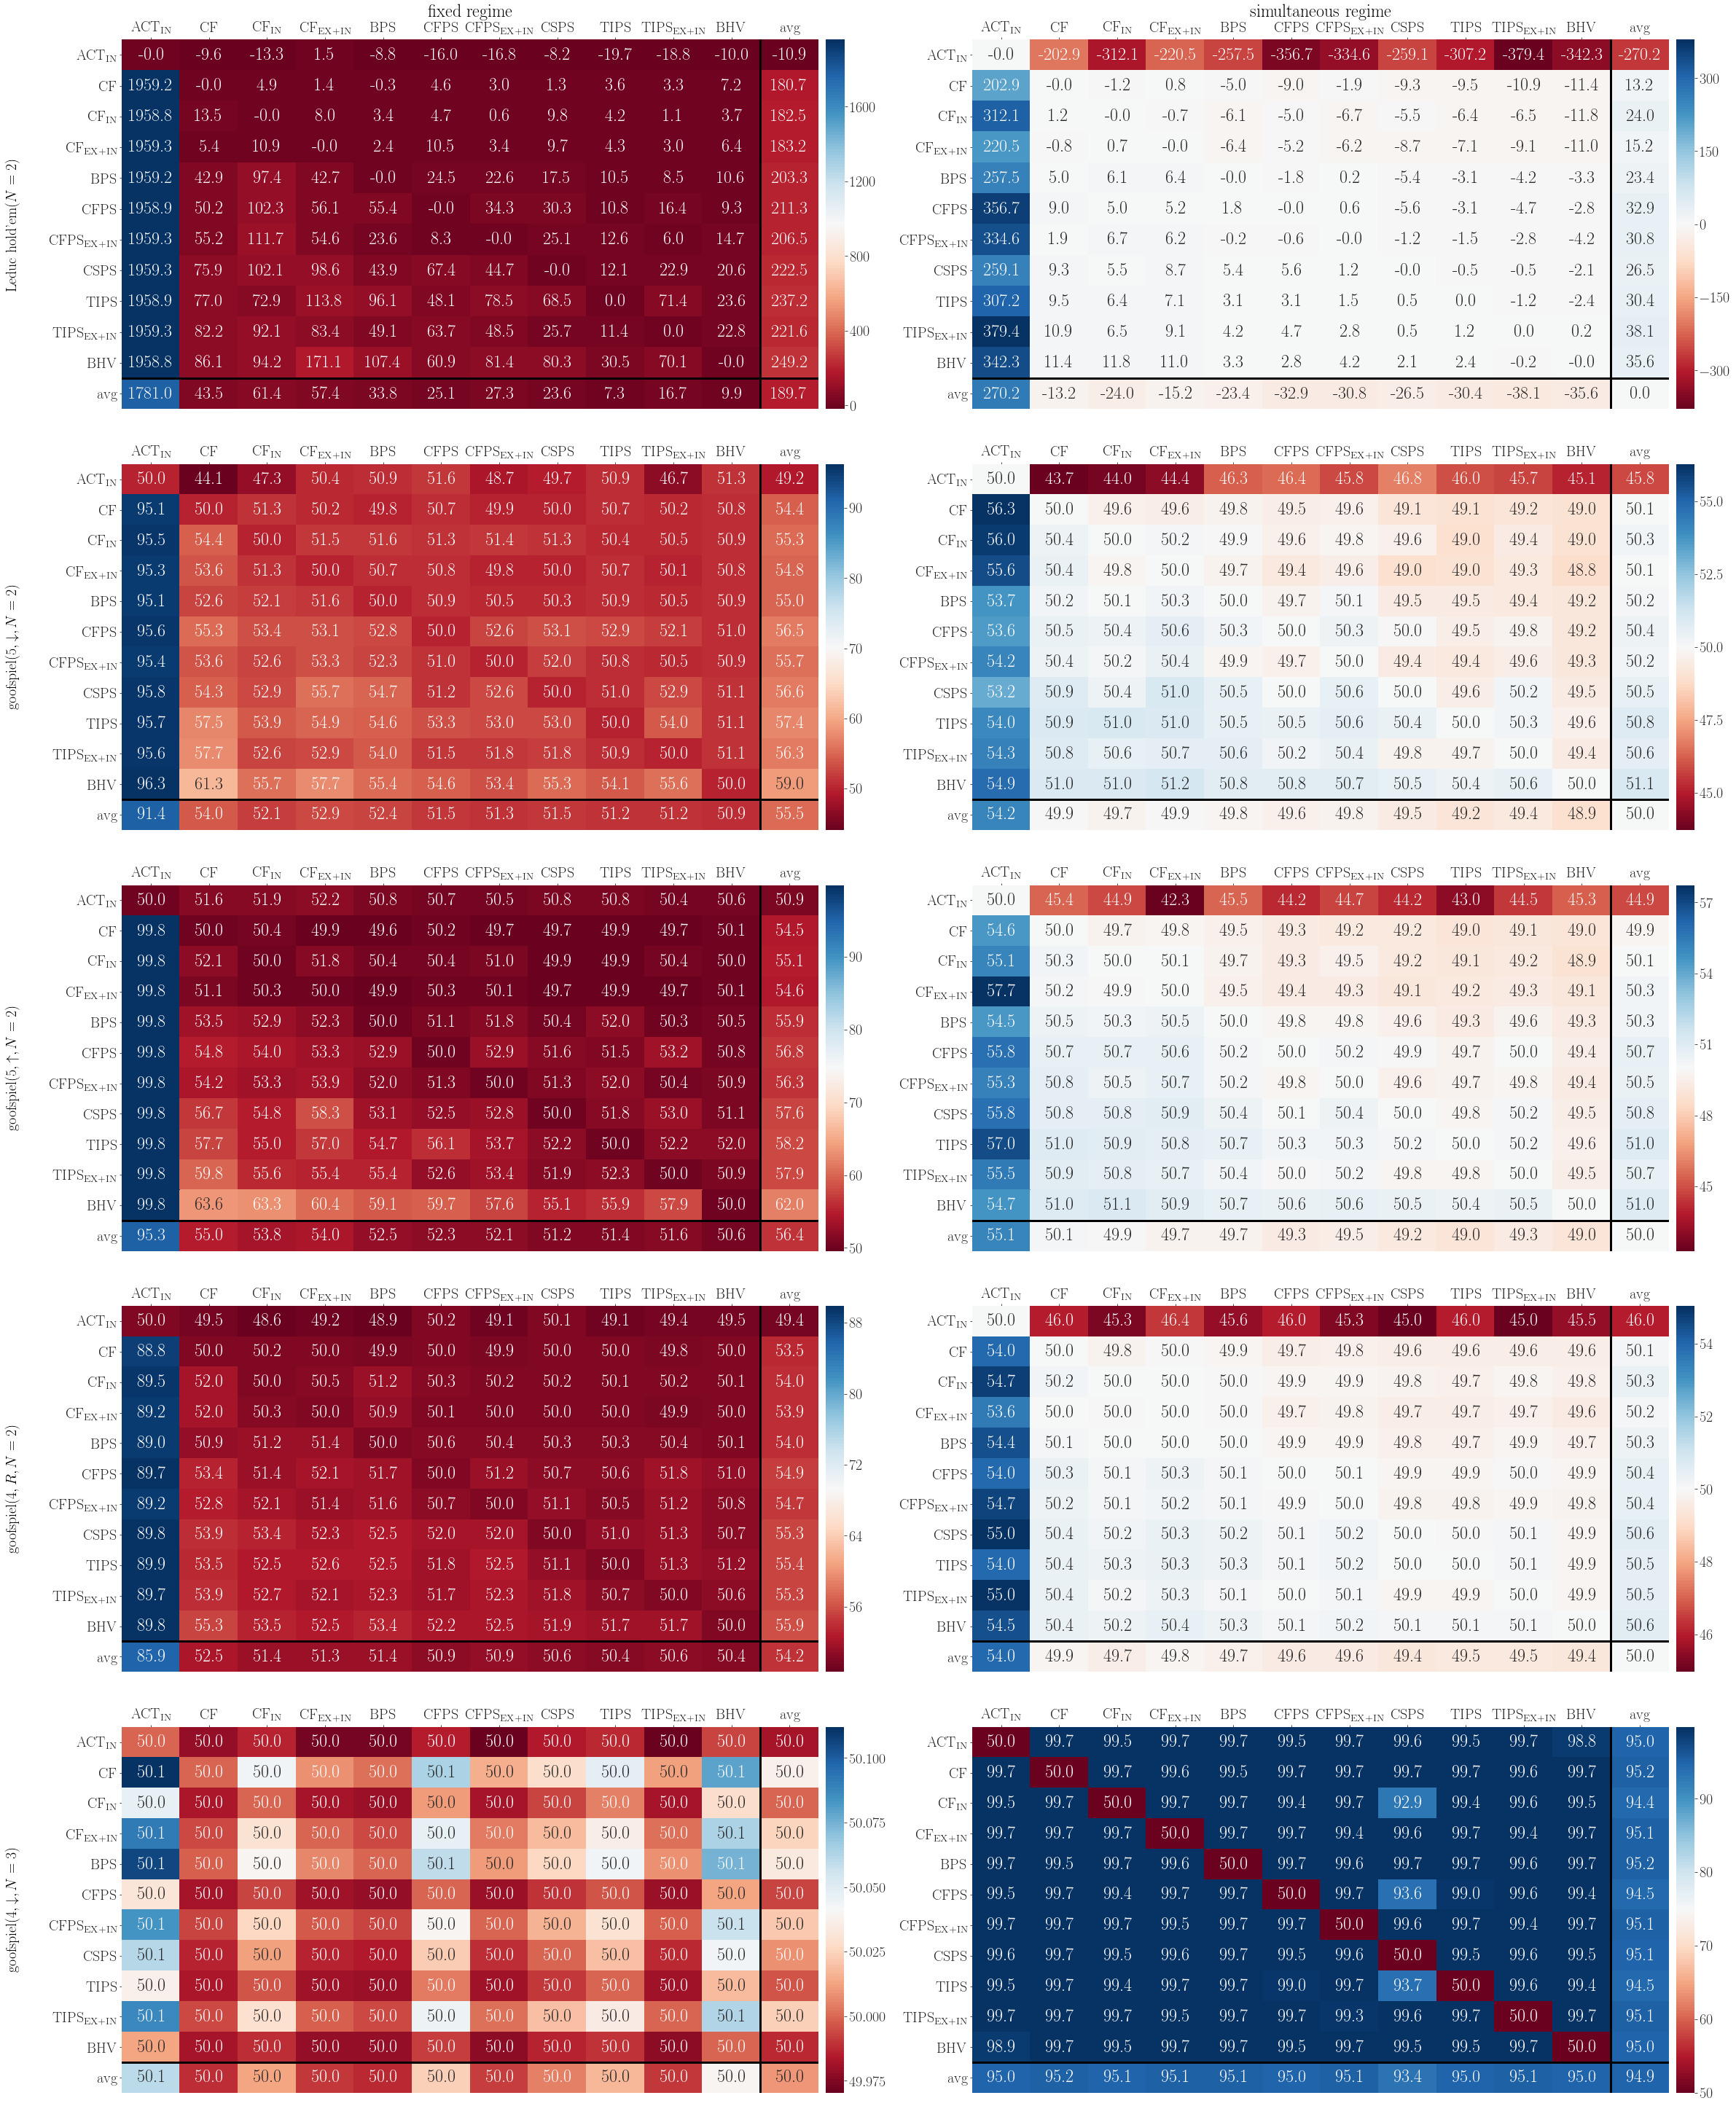

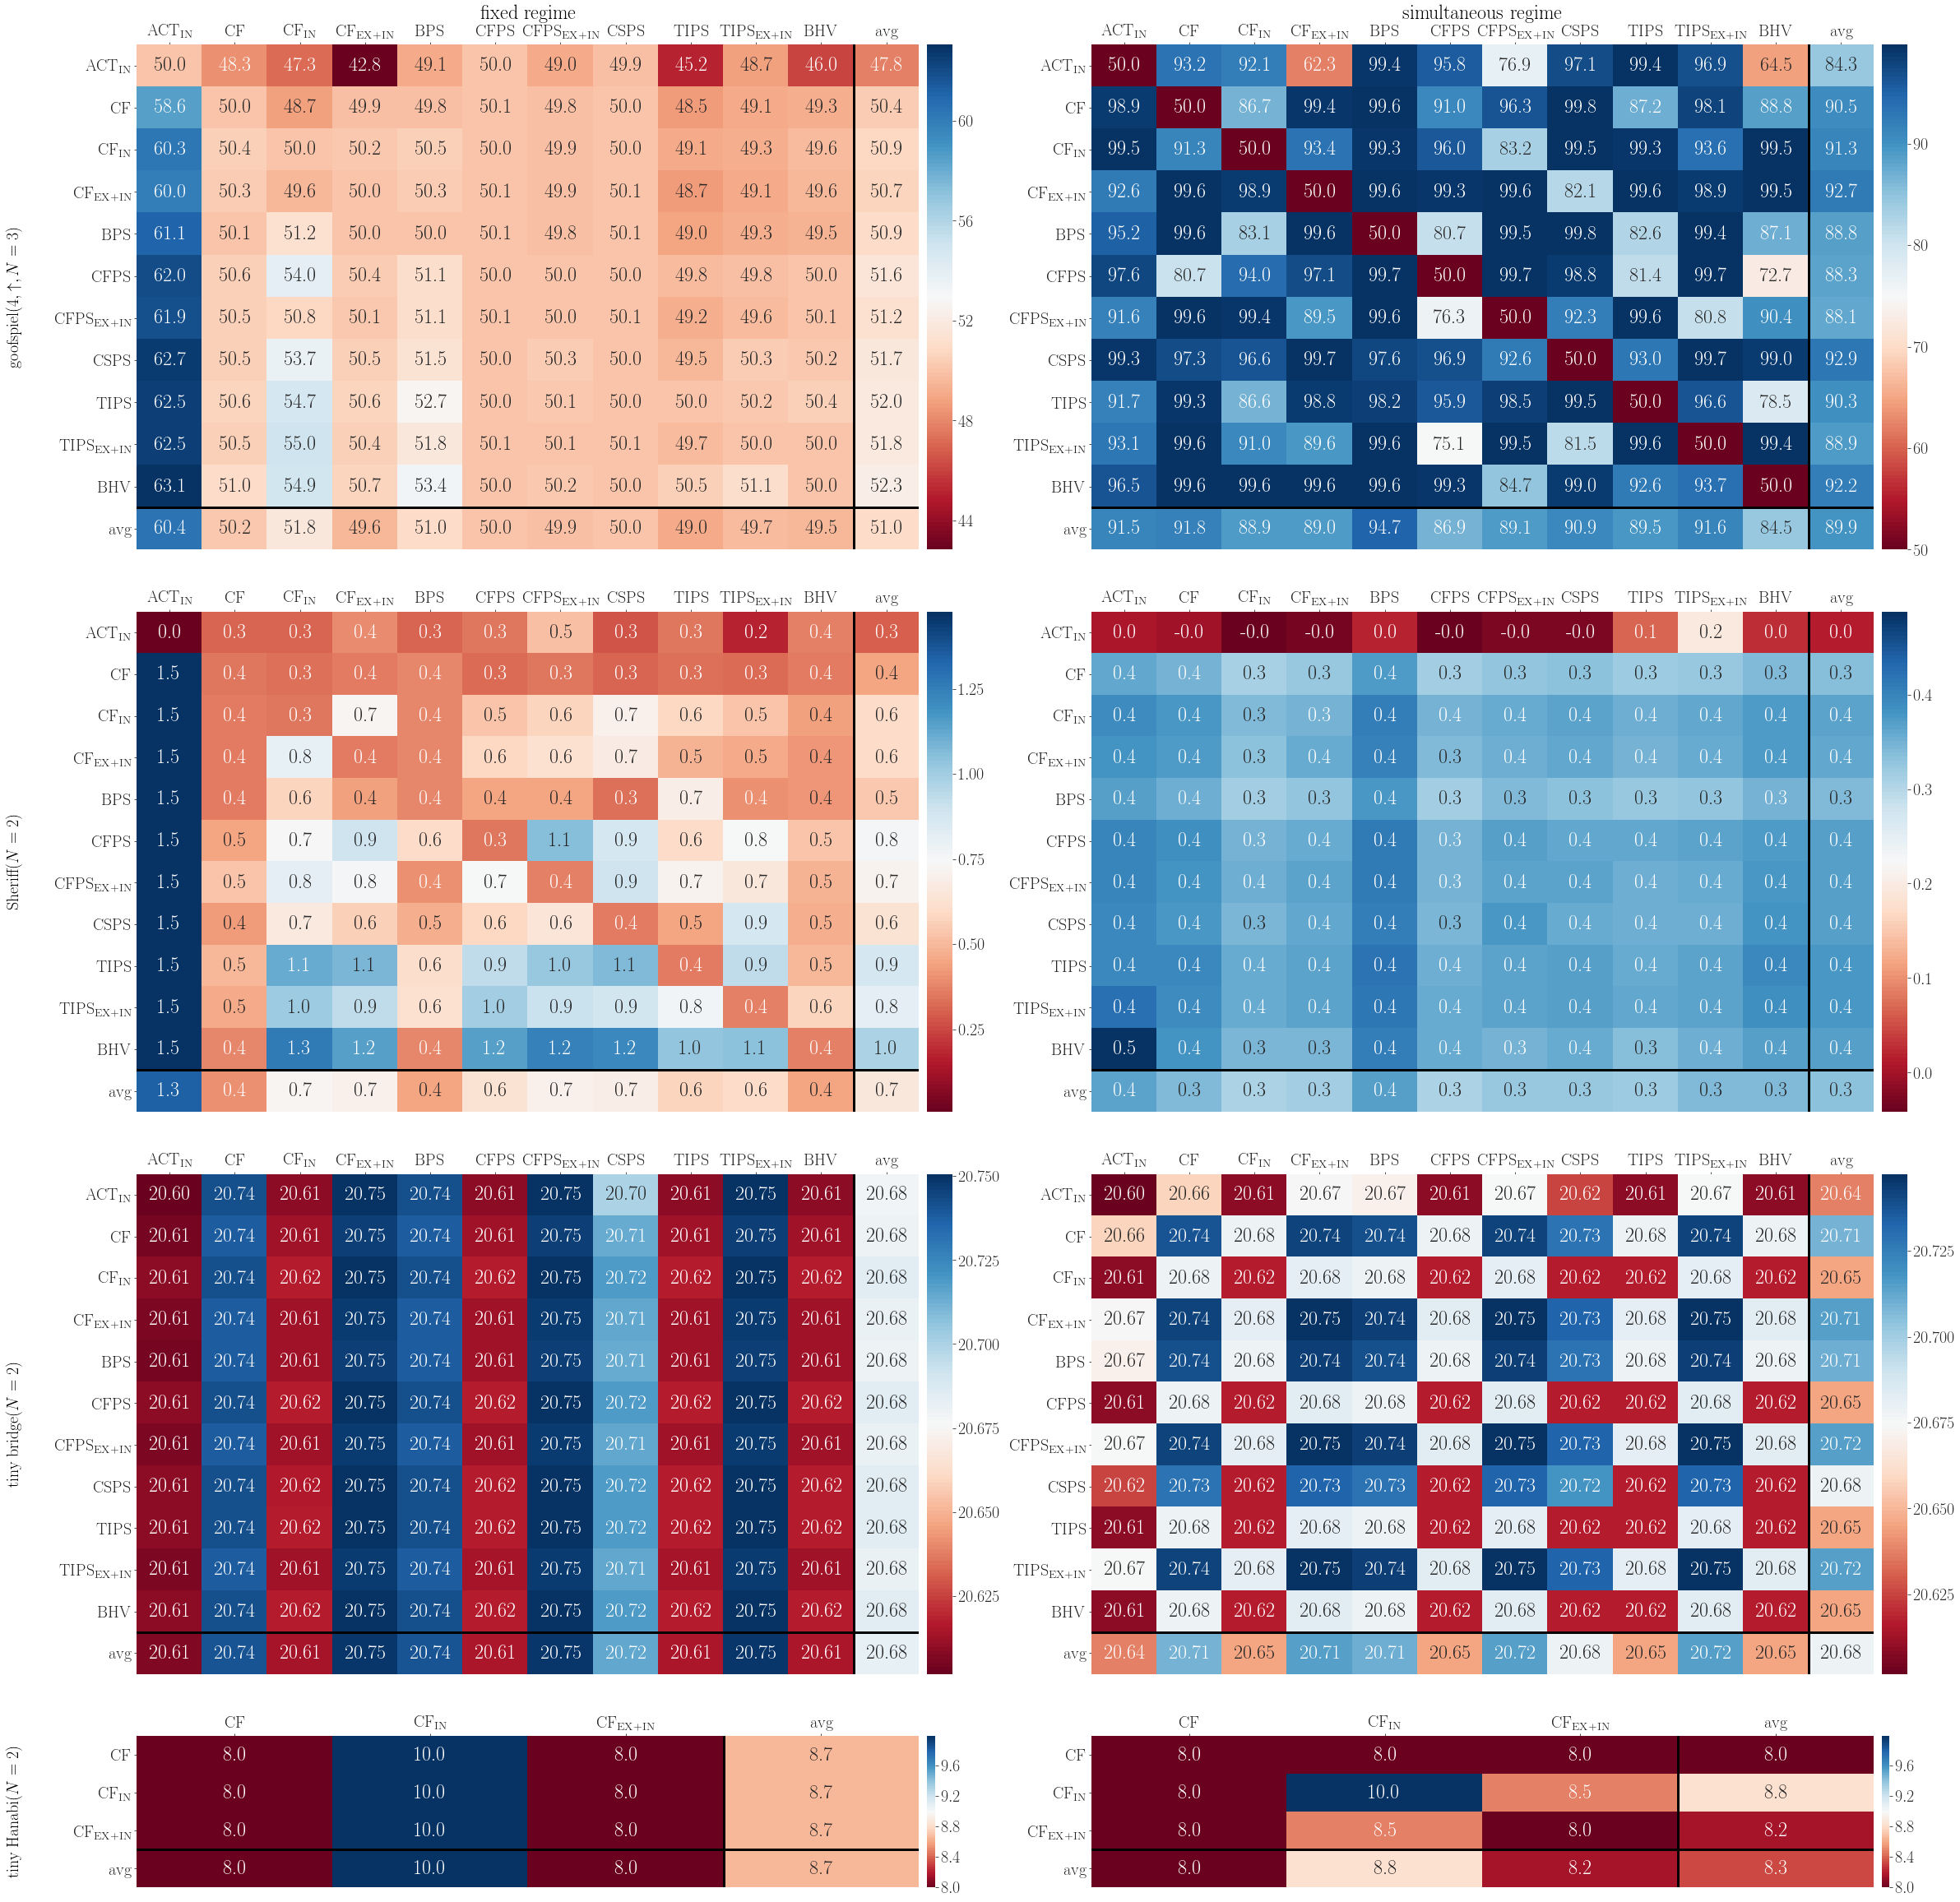

In [15]:
# mcd_plt.set_plt_params(font_size=24)

num_rounds = 1001
num_cols = 2
games = data.games()
num_games1 = len(games)
num_games1 = int(np.ceil(num_games1 / 2))
fig, axes_list = plt.subplots(
    num_games1,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 8 * num_games1),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1] + [0.99] * (num_games1 - 1)})
axes_list[0, 1].set_title('fixed regime')
axes_list[0, 2].set_title('simultaneous regime')

num_games2 = int(np.floor(len(games) / 2))
fig2, axes_list2 = plt.subplots(
    num_games2,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 8 * num_games2),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1] + [0.99]*(num_games2 - 2) + [0.3]})
axes_list2[0, 1].set_title('fixed regime')
axes_list2[0, 2].set_title('simultaneous regime')

axes_list = np.concatenate([axes_list, axes_list2], axis=0)
for i, game in enumerate(games):
    print(game)
    axes_list[i, 2].sharex(axes_list[i, 1])
    axes_list[i, 2].sharey(axes_list[i, 1])
#     axes_list[i, 2].yaxis.set_visible(False)

    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "fixed"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = mcd_tournament.without_br_row(data.time_avg_fixed_table(game, num_rounds))
        
    fmt = "0.1f"
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
        fmt = "0.1f"
    elif game == 'tiny_bridge':
        fmt = "0.2f"
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 1],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "sim"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = data.time_avg_sim_table(game, num_rounds)
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 2],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    axes_list[i, 0].axis('off')
    axes_list[i, 0].text(0, 0.5, mcd_tournament.game_label(game),
                         horizontalalignment='left',
                         verticalalignment='center',
                         rotation=90,
                         transform=axes_list[i, 0].transAxes)
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.22, hspace=0.15)
fig.savefig(f'../results/heatmaps.{date}-1.pdf')

fig2.tight_layout(pad=0.1)
fig2.subplots_adjust(wspace=0.22, hspace=0.15)
heatmap_plot_file = f'../results/heatmaps.{date}-2.pdf'
fig2.savefig(heatmap_plot_file)
!pdfcrop {heatmap_plot_file} {heatmap_plot_file}

# mcd_plt.set_plt_params(font_size=20)

In [16]:
_algs = [
    'A-EFR_IN',
    'CFR',
    'CFR_IN',
    'BPS-EFR',
    'CFPS-EFR',
    'CSPS-EFR',
    'TIPS-EFR',
    'BEHAV-EFR',
]
_alg_label_map = {
    'CFR': r'\textsc{cf}',
    'CFR_IN': r'\textsc{cf}\textsubscript{\INT}',
    'A-EFR_IN': r'\textsc{act}\textsubscript{\INT}',
    'CSPS-EFR': r'\textsc{csps}',
    'CFPS-EFR': r'\textsc{cf}',
    'TIPS-EFR': r'\textsc{tips}',
    'BPS-EFR': r'\textsc{bps}',
    'BEHAV-EFR': r'\textsc{bhv}',
}

def alg_labels(alg_tags):
    return [
      _alg_label_map[tag]
      for tag in alg_tags
    ]

def alg_sort_key(tag):
  return _algs.index(tag)


def alg_sort_keys(tags):
  return pd.Index([alg_sort_key(tag) for tag in tags], name=tags.name)


def with_sorted_algs(df):
  return df.sort_index(axis=0, key=alg_sort_keys)

In [17]:
fmt = r'{:.0%}\%'

In [18]:
_game_tags = [
    'goofspiel_ascending',
    'goofspiel_ascending_3p',
    'sheriff',
]
_modes = [
    'fixed',
    'sim',
]
_qs = ' & '.join(
    [
        f'game_tag == {list(_game_tags)}',
        f'mode == {list(_modes)}',
        f'row_alg == {list(_algs)}',
        f'col_alg == {list(_algs)}'
    ]
)
_df = data.data.query(_qs)
_df = _df.pivot(
    index=['t', 'col_alg'],
    columns=['row_alg', 'mode', 'game_tag'],
    values='value'
).mean().unstack(level=[1, 2])
_df = with_sorted_algs(_df)
_df = _df.sort_index(axis='columns', level=1, key=(
    lambda x: pd.Index([_game_tags.index(y) for y in x], name=x.name)
))
_df = _df.sort_index(axis='columns', level=0, key=(
    lambda x: pd.Index([_modes.index(y) for y in x], name=x.name)
))
def _f(col):
    if col.name[1] == 'goofspiel_ascending' or col.name[1] == 'goofspiel_ascending_3p':
        col = goofspiel_score_to_win_percentage(col) / 100.0
    return col
_df = _df.apply(_f, axis='rows')
_df.index = pd.Index(alg_labels(_df.index))
print(_df.to_string(
    formatters=(
        ' & {:.2f}'.format,
        ' & {:.2f}'.format,
        ' & {:.2f}'.format,
        ' & {:.2f}'.format,
        ' & {:.2f}'.format,
        ' & {:.2f}'.format,
    )
))

mode                                           fixed                                                sim                               
game_tag                         goofspiel_ascending goofspiel_ascending_3p sheriff goofspiel_ascending goofspiel_ascending_3p sheriff
\textsc{act}\textsubscript{\INT}              & 0.51                 & 0.48  & 0.28              & 0.45                 & 0.86  & 0.00
\textsc{cf}                                   & 0.56                 & 0.51  & 0.48              & 0.50                 & 0.88  & 0.34
\textsc{cf}\textsubscript{\INT}               & 0.57                 & 0.51  & 0.60              & 0.50                 & 0.92  & 0.37
\textsc{bps}                                  & 0.58                 & 0.51  & 0.58              & 0.50                 & 0.85  & 0.34
\textsc{cf}                                   & 0.58                 & 0.52  & 0.70              & 0.51                 & 0.84  & 0.37
\textsc{csps}                                 & 0.59   

## Figure for HR-DT presentation

In [22]:
_algs = [
    'A-EFR_IN',
    'CFR',
#     'CSPS-EFR',
    'TIPS-EFR',
    'BEHAV-EFR',
]
_alg_label_map = {
    'CFR': r'CFR',
    'A-EFR_IN': r'$\textsc{ACT}_{\textsc{IN}}$',
#     'CSPS-EFR': r'$\approx$ICFR',
    'TIPS-EFR': r'$\textsc{TIPS}$',
    'BEHAV-EFR': r'$\textsc{BHV}$',
}
_alg_color = {k: v for k, v in alg_color.items()}
_alg_color['CFR'] = light_colors[0]

goofspiel_ascending
goofspiel_ascending_3p
sheriff
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/learning_curves_hr_dt.fixed.jun6_2021.pdf'.
goofspiel_ascending
goofspiel_ascending_3p
sheriff
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/learning_curves_hr_dt.sim.jun6_2021.pdf'.


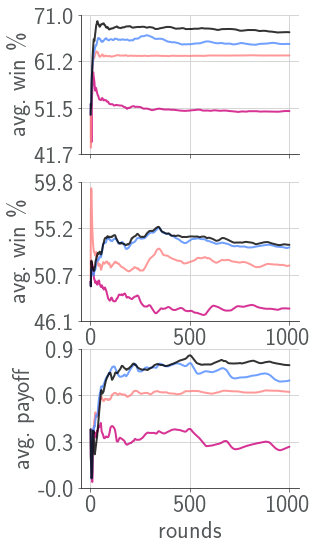

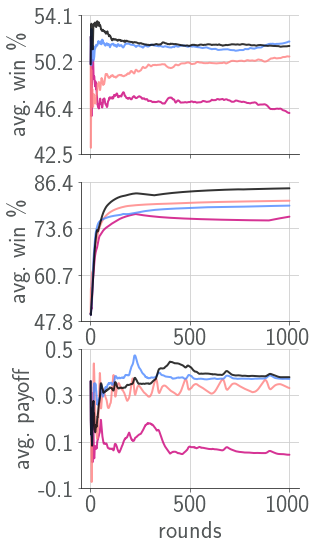

In [23]:
_data_bak = data.data
data.data = data.data.query(f'col_alg == {_algs} & row_alg == {_algs}')

charcoal = '#545859'
mcd_plt.set_plt_params(font_size=24, use_serif=False, color=charcoal)

ylim_by_game = {}
games = ['goofspiel_ascending', 'goofspiel_ascending_3p', 'sheriff']
modes = ['fixed', 'sim']

for k, mode in enumerate(modes):
    fig, axes_list = learning_curves_subplots(games, [_algs])
    plot_all_round_learning_curves(
        axes_list, mode,
        alg_groups_list=[_algs], col_algs=list(all_algs), games=games,
        label_fn=lambda alg: _alg_label_map[alg],
        color_fn=lambda alg: _alg_color[alg],
        show_legend=False)
    for i in range(axes_list.shape[0]):
        xticks = learning_curves_xticks(axes_list[i, 0])
        for j in range(axes_list.shape[1]):
            learning_curves_set_yticks(axes_list[i, j])
            if j > 0:
                hide_ytick_labels(axes_list[i, j])
    for i, game_tag in each_game_in_round_learning_curve(games=games):
        ax = axes_list[i, 0]
        set_learning_curve_ylabel(game_tag, ax, avg=True)
        
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
        ax.grid("on")
        ax.tick_params(colors=charcoal)
    axes_list[0, 0].set_xticklabels([])
    axes_list[-1, 0].set_xlabel('rounds')
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0, hspace=0.2)
    sns.despine()
    if k == 0:
        legend_handles = axes_list[0, 0].get_legend_handles_labels()
    plot_file = f'../results/learning_curves_hr_dt.{mode}.{date}.pdf'
    plt.savefig(plot_file, transparent=True)
    !pdfcrop {plot_file} {plot_file}
data.data = _data_bak

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `../results/learning_curves_hr_dt.jun6_2021.legend.pdf'.


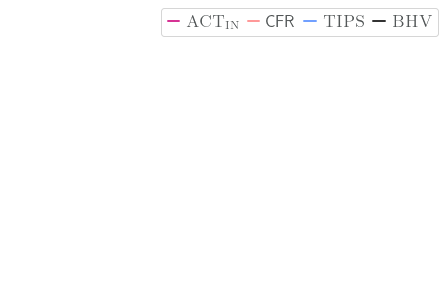

In [24]:
legend_fig = plt.figure()
ax = legend_fig.add_subplot()
ax.clear()
ax.axis('off')
legend_fig.legend(*legend_handles,
                  ncol=4,
                  fontsize='x-small',
                  columnspacing=0.5,
                  labelspacing=0.5,
                  handletextpad=0.4,
                  handlelength=0.7)
plt.tight_layout(pad=0)
legend_file = f'../results/learning_curves_hr_dt.{date}.legend.pdf'
plt.savefig(legend_file, transparent=True)
!pdfcrop {legend_file} {legend_file}